In [232]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from  statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
plt.rcParams["figure.figsize"] = [18, 8]

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Этот набор данных содержит информацию о погоде в городе Дели(Индия)
# с 1 января 2013 года по 24 апреля 2017 года.
Данные имеют несколько параметров:
1) Дата (date);
2) Влажность (humidity);
3) Средняя температура (meantemp);
4) Скорость ветра (wind_speed);
5) Среднее давление (meanpressure).

In [3]:
df_train = pd.read_csv('data/DailyDelhiClimateTrain.csv', index_col='date', parse_dates=True)
df_test = pd.read_csv('data/DailyDelhiClimateTest.csv', index_col='date', parse_dates=True)
df = pd.concat([df_train, df_test])
df_train, df_test = df[:1097], df[1097:]

Посмотрим данные:

In [4]:
print(f'Кол-во строк в тренировочных данных: {len(df_train)}')
print(f'Кол-во строк в тестовых данных: {len(df_test)}')
print(f'Кол-во строк во всем датасете: {len(df)}')

Кол-во строк в тренировочных данных: 1097
Кол-во строк в тестовых данных: 479
Кол-во строк во всем датасете: 1576


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1576 entries, 2013-01-01 to 2017-04-24
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1576 non-null   float64
 1   humidity      1576 non-null   float64
 2   wind_speed    1576 non-null   float64
 3   meanpressure  1576 non-null   float64
dtypes: float64(4)
memory usage: 61.6 KB


Все столбцы имеют тип float

In [6]:
df.isnull().sum()

meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

Пропусков в тренировочных данных нет.

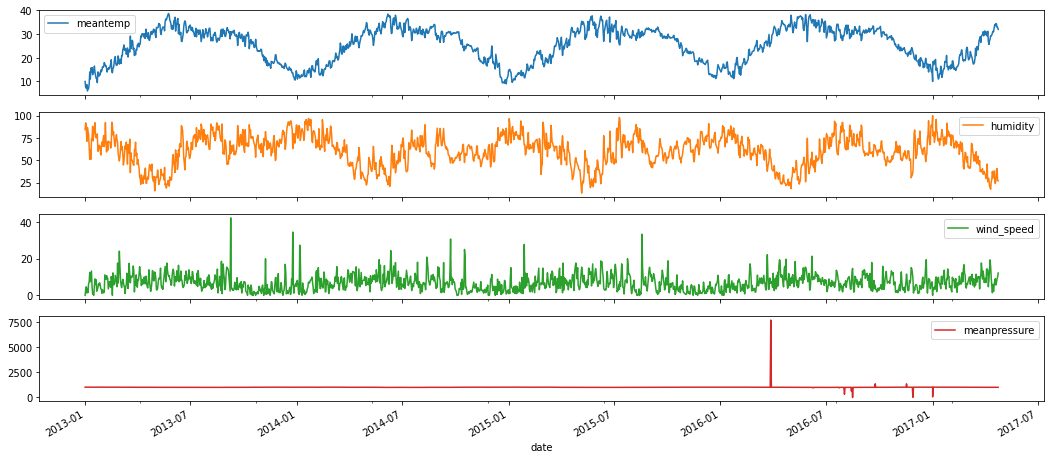

In [7]:
df.plot(subplots=True)
plt.show()

In [8]:
for c in df.columns:
    af = adfuller(df[c])
    print(c)
    print(f'adf: {af[0]}')
    print(f'p-value: {af[1]}')
    print(f'Critical values: {af[4]}')
    if af[0] > af[4]['5%']:
        print('Ряд не стационарен')
    else:
        print('Ряд стационарен')
    print('\n')

meantemp
adf: -2.3791899484520926
p-value: 0.14769623489792355
Critical values: {'1%': -3.4345353407734733, '5%': -2.86338857621683, '10%': -2.567754150088293}
Ряд не стационарен


humidity
adf: -3.6289421593858777
p-value: 0.005231221485558025
Critical values: {'1%': -3.4345487774977768, '5%': -2.8633945067663817, '10%': -2.5677573081032214}
Ряд стационарен


wind_speed
adf: -4.01322099000784
p-value: 0.0013428427295095503
Critical values: {'1%': -3.434573182279212, '5%': -2.863405278205157, '10%': -2.567763043900464}
Ряд стационарен


meanpressure
adf: -39.54736593013774
p-value: 0.0
Critical values: {'1%': -3.434508723681996, '5%': -2.863376828187341, '10%': -2.567747894280675}
Ряд стационарен




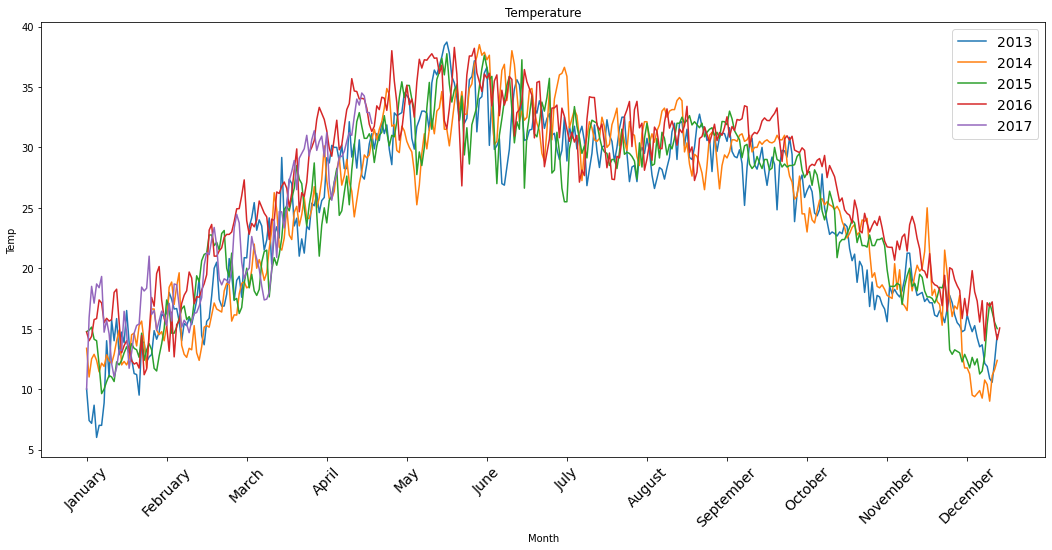

In [9]:
dates = pd.to_datetime(df.index)
plt.title('Temperature')
for y in dates.year.unique():
    plt.plot(df['meantemp'][dates.year==y].values, label=y)
plt.xlabel('Month')
plt.ylabel('Temp')
plt.xticks(np.arange(0, 365, 32), labels=dates.month_name().unique(), rotation=45, fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [10]:
df_w = pd.DataFrame(df_train['meantemp'].resample('W').mean())
df_m = pd.DataFrame(df_train['meantemp'].resample('M').mean())
df_d = pd.DataFrame(df_train['meantemp'].resample('d').mean())
df_test_w = pd.DataFrame(df_test['meantemp'].resample('W').mean())
df_test_m = pd.DataFrame(df_test['meantemp'].resample('M').mean())
df_test_d = pd.DataFrame(df_test['meantemp'].resample('d').mean())

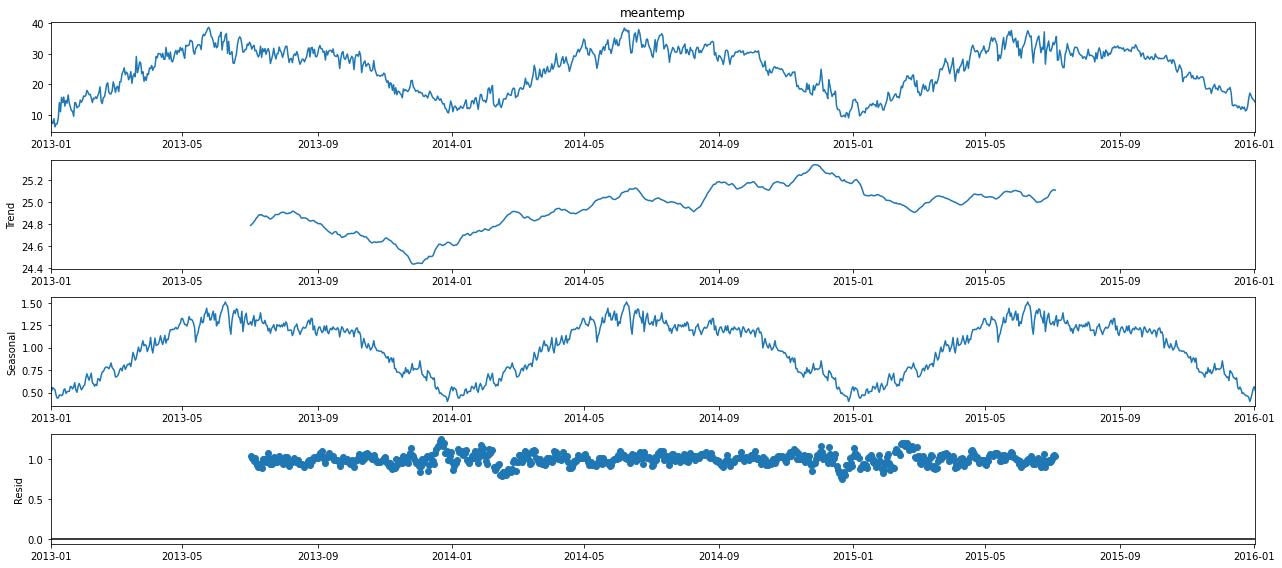

In [11]:
decomp = seasonal_decompose(df_d['meantemp'], model='multiplicative', period=365)
decomp.plot()
plt.show()

## SARIMAX

### По месяцам

In [69]:
model = SARIMAX(df_m,
                  order=(2,0,2),
                  seasonal_order=(2,1,0,12))
results=model.fit()
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                            meantemp   No. Observations:                   37
Model:             SARIMAX(2, 0, 2)x(2, 1, [], 12)   Log Likelihood                 -36.842
Date:                             Tue, 26 Apr 2022   AIC                             87.685
Time:                                     23:37:41   BIC                             96.217
Sample:                                 01-31-2013   HQIC                            90.051
                                      - 01-31-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1323     11.484      0.012      0.991     -22.376      22.640
ar.L2          0.8479      

In [70]:
predictions= results.forecast(steps=16)

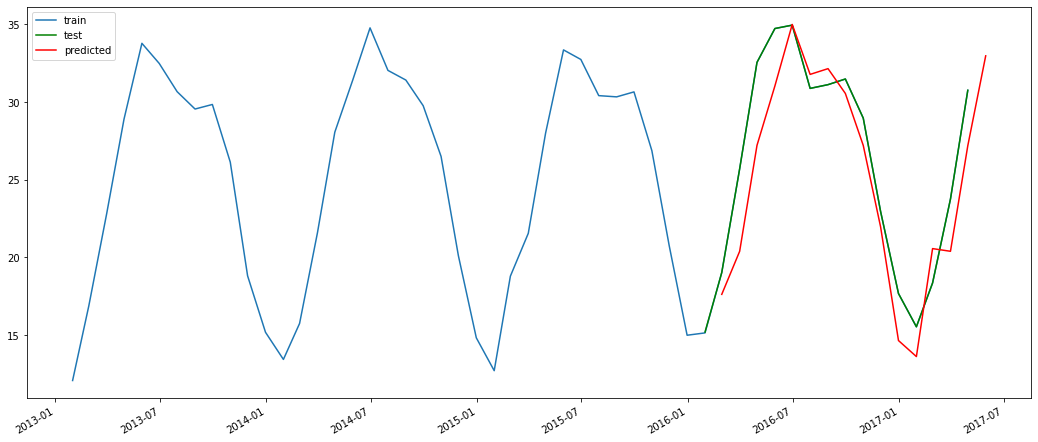

In [71]:
fig, ax = plt.subplots()
plt.plot(df['meantemp'].resample('M').mean())
plt.plot(df_test_m, color='green')
predictions.plot(legend=True, color='red')
ax.legend(['train', 'test', 'predicted'])
plt.show()

In [72]:
mse = mean_squared_error(df_test_m, predictions)
print(f'MSE = {round(mse,3)}')

MSE = 13.953


In [73]:
rmse = np.sqrt(mse)
print(f'RMSE = {round(rmse,3)}')

RMSE = 3.735


### По неделям

In [75]:
model = SARIMAX(df_w,
                  order=(2,0,2),
                  seasonal_order=(2,1,0,52))
results=model.fit()
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                            meantemp   No. Observations:                  157
Model:             SARIMAX(2, 0, 2)x(2, 1, [], 52)   Log Likelihood                -221.826
Date:                             Tue, 26 Apr 2022   AIC                            457.653
Time:                                     23:39:13   BIC                            476.230
Sample:                                 01-06-2013   HQIC                           465.181
                                      - 01-03-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4764      0.383      1.243      0.214      -0.275       1.227
ar.L2         -0.6291      

In [76]:
predictions= results.forecast(steps=70)

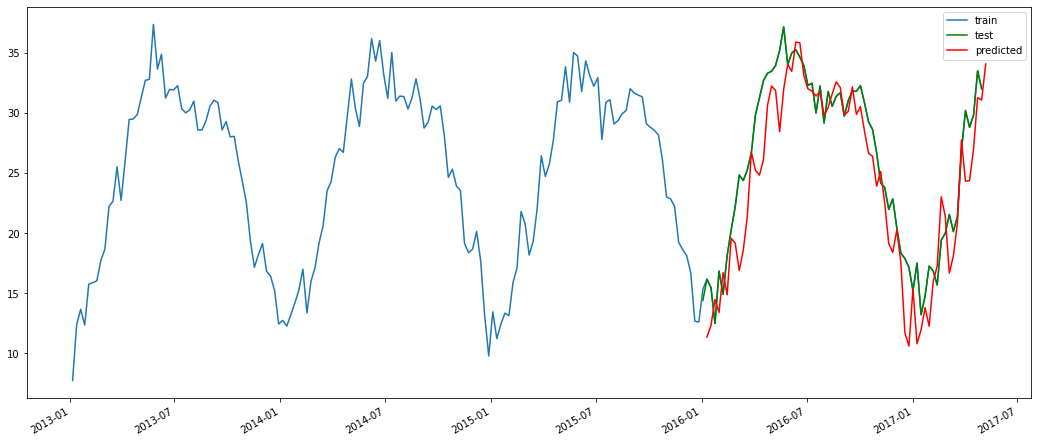

In [77]:
fig, ax = plt.subplots()
plt.plot(df['meantemp'].resample('W').mean())
plt.plot(df_test_w, color='green')
predictions.plot(legend=True, color='red')
ax.legend(['train', 'test', 'predicted'])
plt.show()

In [78]:
mse = mean_squared_error(df_test_w, predictions)
print(f'MSE = {round(mse,3)}')

MSE = 10.146


In [79]:
rmse = np.sqrt(mse)
print(f'RMSE = {round(rmse,3)}')

RMSE = 3.185


### По дням

In [51]:
train = [x for x in df_d['meantemp']]
predictions = []
for i in range(len(df_test_d['meantemp'])):
    model = SARIMAX(train,
                    order=(1,1,1),
                    seasonal_order=(0,0,1, 12))
    pred = model.fit().forecast()[0]
    predictions.append(pred)
    train.append(df_test_d['meantemp'][i])

In [ ]:
predictions = pd.DataFrame(predictions, index=df_test_d.index)

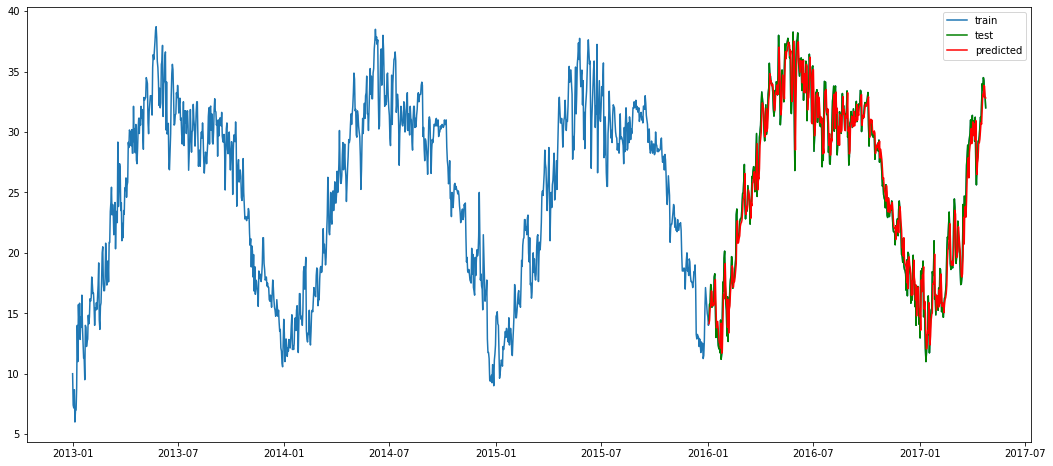

In [53]:
fig, ax = plt.subplots()
plt.plot(df['meantemp'].resample('D').mean())
plt.plot(df_test_d, color='green')
plt.plot(predictions, color='red')
ax.legend(['train', 'test', 'predicted'])
plt.show()

In [56]:
mse = mean_squared_error(df_test['meantemp'][:478], predictions)
print(f'MSE = {round(mse,3)}')

MSE = 2.062


In [57]:
rmse = np.sqrt(mse)
print(f'RMSE = {round(rmse, 3)}')

RMSE = 1.436


## ARIMA

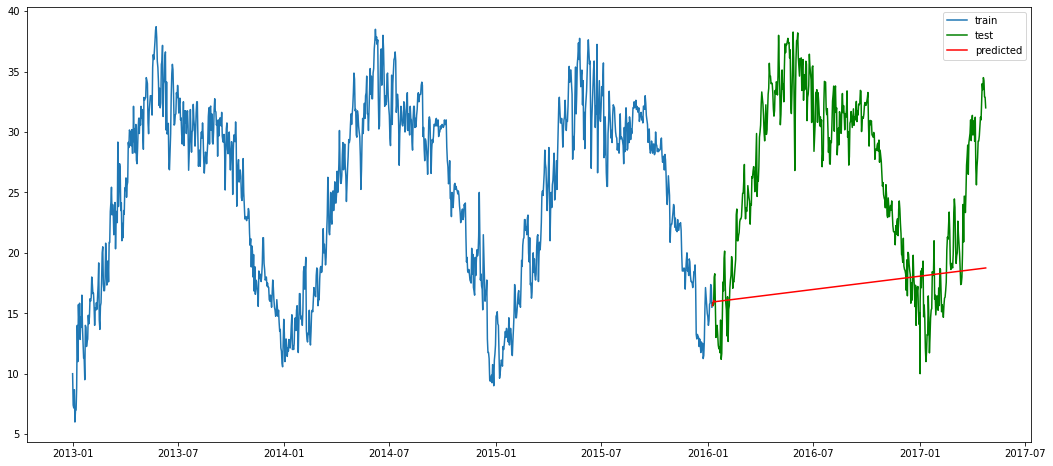

In [266]:
train = df['meantemp'][:int(np.floor((len(df)/100)*70))]
test = df['meantemp'][int(np.floor((len(df)/100)*70)):]

model = ARIMA(train, order=(3, 2, 1))
fitted = model.fit()

fc = fitted.get_forecast(len(df['meantemp'][int(np.floor((len(df)/100)*70)):]))
conf = fc.conf_int(alpha=0.05)

predictions = pd.Series(fc.predicted_mean, index=test.index)
lower_series = pd.Series(conf.iloc[:, 0], index=test.index)
upper_series = pd.Series(conf.iloc[:, 1], index=test.index)

plt.plot(train)
plt.plot(test, color='green')
plt.plot(predictions, color='red')
plt.legend(['train', 'test', 'predicted'])
plt.show()

In [259]:
mse = mean_squared_error(test, predictions)
print(f'MSE = {round(mse,3)}')

MSE = 127.446


In [260]:
rmse = np.sqrt(mse)
print(f'RMSE = {round(rmse,3)}')

RMSE = 11.289


## LSTM

### По месяцам

In [169]:
train = df_train[["meantemp"]].resample("M").mean()
test = df_test[["meantemp"]].resample("M").mean()

In [170]:
scaler = StandardScaler()
scaler.fit(df_m)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(train)
n_input = 9
n_features = 1
generator = TimeseriesGenerator(train_scaled, train_scaled, length=n_input, batch_size=1)

In [171]:
model = Sequential()
model.add(LSTM(128, activation="relu", return_sequences=True, input_shape=(n_input, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 9, 128)            66560     
                                                                 
 dropout_6 (Dropout)         (None, 9, 128)            0         
                                                                 
 lstm_7 (LSTM)               (None, 9, 128)            131584    
                                                                 
 dropout_7 (Dropout)         (None, 9, 128)            0         
                                                                 
 lstm_8 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 25)               

In [172]:
history = model.fit(generator, epochs=25)

Epoch 1/25
28/28 [==============================] - 4s 9ms/step - loss: 0.7215 - accuracy: 0.0000e+00
Epoch 2/25
28/28 [==============================] - 0s 8ms/step - loss: 0.2768 - accuracy: 0.0000e+00
Epoch 3/25
28/28 [==============================] - 0s 8ms/step - loss: 0.1116 - accuracy: 0.0000e+00
Epoch 4/25
28/28 [==============================] - 0s 8ms/step - loss: 0.1199 - accuracy: 0.0000e+00
Epoch 5/25
28/28 [==============================] - 0s 9ms/step - loss: 0.0997 - accuracy: 0.0000e+00
Epoch 6/25
28/28 [==============================] - 0s 9ms/step - loss: 0.1115 - accuracy: 0.0000e+00
Epoch 7/25
28/28 [==============================] - 0s 9ms/step - loss: 0.1093 - accuracy: 0.0000e+00
Epoch 8/25
28/28 [==============================] - 0s 8ms/step - loss: 0.0718 - accuracy: 0.0000e+00
Epoch 9/25
28/28 [==============================] - 0s 8ms/step - loss: 0.0968 - accuracy: 0.0000e+00
Epoch 10/25
28/28 [==============================] - 0s 8ms/step - loss: 0.0948 - 

In [173]:
predictions_scaled_lstm = []
first_eval_batch = train_scaled[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
for i in range(len(test)):
     current_pred = model.predict(current_batch)[0]
     predictions_scaled_lstm.append(current_pred)
     current_batch =  np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [174]:
predictions_lstm = scaler.inverse_transform(predictions_scaled_lstm)

In [175]:
train = pd.DataFrame(train.values, index=range(0, len(train)))
test = pd.DataFrame(test.values, index=range(len(train), len(test) + len(train)))
predictions = pd.DataFrame(predictions_lstm, index=range(len(train), len(test) + len(train)))

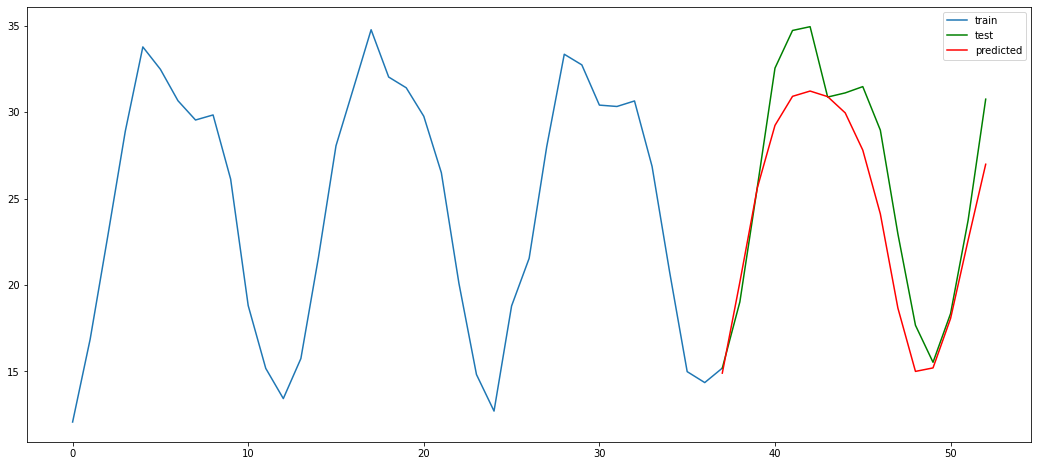

In [176]:
fig, ax = plt.subplots()
plt.plot(np.append(train, test.values[0]))
plt.plot(test, color='green')
plt.plot(predictions, color="red")
ax.legend(['train', 'test', 'predicted'])
plt.show()

In [177]:
mse = mean_squared_error(test, predictions_lstm)
print(f'MSE = {round(mse,3)}')

MSE = 7.519


In [178]:
rmse = np.sqrt(mse)
print(f'RMSE = {round(rmse,3)}')

RMSE = 2.742


### По неделям

In [198]:
train = df_train[["meantemp"]].resample("W").mean()
test = df_test[["meantemp"]].resample("W").mean()

In [199]:
scaler = StandardScaler()
scaler.fit(df_w)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(train)
n_input = 9
n_features = 1
generator = TimeseriesGenerator(train_scaled, train_scaled, length=n_input, batch_size=1)

In [200]:
model = Sequential()
model.add(LSTM(128, activation="relu", return_sequences=True, input_shape=(n_input, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 9, 128)            66560     
                                                                 
 dropout_18 (Dropout)        (None, 9, 128)            0         
                                                                 
 lstm_19 (LSTM)              (None, 9, 128)            131584    
                                                                 
 dropout_19 (Dropout)        (None, 9, 128)            0         
                                                                 
 lstm_20 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_20 (Dropout)        (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 25)               

In [206]:
history = model.fit(generator, epochs=100)

Epoch 1/100
148/148 [==============================] - 1s 9ms/step - loss: 0.0767 - accuracy: 0.0000e+00
Epoch 2/100
148/148 [==============================] - 2s 12ms/step - loss: 0.0749 - accuracy: 0.0000e+00
Epoch 3/100
148/148 [==============================] - 3s 19ms/step - loss: 0.0717 - accuracy: 0.0000e+00
Epoch 4/100
148/148 [==============================] - 2s 12ms/step - loss: 0.0635 - accuracy: 0.0000e+00
Epoch 5/100
148/148 [==============================] - 2s 14ms/step - loss: 0.0684 - accuracy: 0.0000e+00
Epoch 6/100
148/148 [==============================] - 3s 19ms/step - loss: 0.0765 - accuracy: 0.0000e+00
Epoch 7/100
148/148 [==============================] - 2s 10ms/step - loss: 0.0786 - accuracy: 0.0000e+00
Epoch 8/100
148/148 [==============================] - 2s 11ms/step - loss: 0.0639 - accuracy: 0.0000e+00
Epoch 9/100
148/148 [==============================] - 2s 15ms/step - loss: 0.0668 - accuracy: 0.0000e+00
Epoch 10/100
148/148 [=========================

In [207]:
predictions_scaled_lstm = []
first_eval_batch = train_scaled[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
for i in range(len(test)):
     current_pred = model.predict(current_batch)[0]
     predictions_scaled_lstm.append(current_pred)
     current_batch =  np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [208]:
predictions_lstm = scaler.inverse_transform(predictions_scaled_lstm)

In [209]:
train = pd.DataFrame(train.values, index=range(0, len(train)))
test = pd.DataFrame(test.values, index=range(len(train), len(test) + len(train)))
predictions = pd.DataFrame(predictions_lstm, index=range(len(train), len(test) + len(train)))

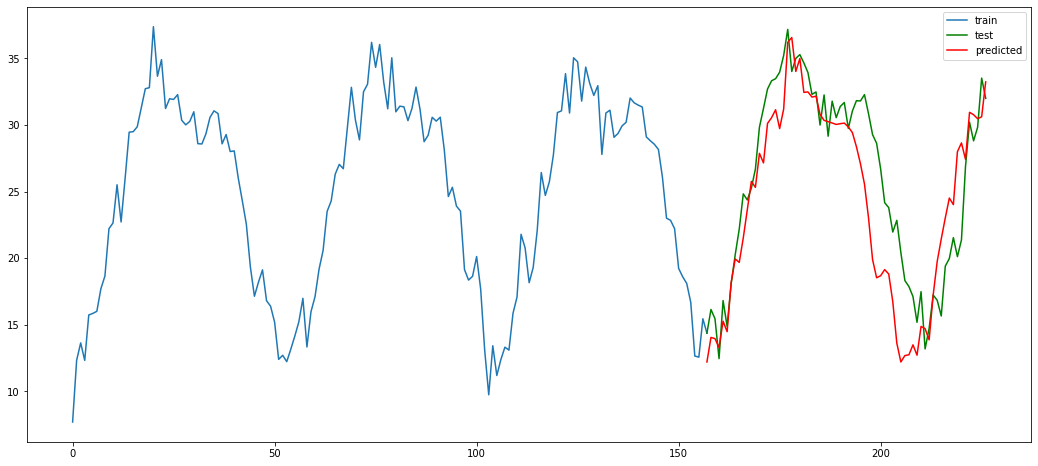

In [211]:
fig, ax = plt.subplots()
plt.plot(np.append(train, test.values[0]))
plt.plot(test, color='green')
plt.plot(predictions, color="red")
ax.legend(['train', 'test', 'predicted'])
plt.show()

In [212]:
mse = mean_squared_error(test, predictions_lstm)
print(f'MSE = {round(mse,3)}')

MSE = 15.173


In [213]:
rmse = np.sqrt(mse)
print(f'RMSE = {round(rmse,3)}')

RMSE = 3.895


### По дням

In [218]:
train = df_train[["meantemp"]].resample("D").mean()
test = df_test[["meantemp"]].resample("D").mean()

In [219]:
scaler = StandardScaler()
scaler.fit(df_d)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(train)
n_input = 9
n_features = 1
generator = TimeseriesGenerator(train_scaled, train_scaled, length=n_input, batch_size=1)

In [220]:
model = Sequential()
model.add(LSTM(128, activation="relu", return_sequences=True, input_shape=(n_input, n_features)))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 9, 128)            66560     
                                                                 
 dropout_21 (Dropout)        (None, 9, 128)            0         
                                                                 
 lstm_22 (LSTM)              (None, 9, 128)            131584    
                                                                 
 dropout_22 (Dropout)        (None, 9, 128)            0         
                                                                 
 lstm_23 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_23 (Dropout)        (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 25)               

In [222]:
history = model.fit(generator, epochs=150)

Epoch 1/150
1088/1088 [==============================] - 20s 19ms/step - loss: 0.0824 - accuracy: 0.0000e+00
Epoch 2/150
1088/1088 [==============================] - 20s 19ms/step - loss: 0.0764 - accuracy: 0.0000e+00
Epoch 3/150
1088/1088 [==============================] - 19s 17ms/step - loss: 0.0768 - accuracy: 0.0000e+00
Epoch 4/150
1088/1088 [==============================] - 18s 17ms/step - loss: 0.0754 - accuracy: 0.0000e+00
Epoch 5/150
1088/1088 [==============================] - 19s 18ms/step - loss: 0.0765 - accuracy: 0.0000e+00
Epoch 6/150
1088/1088 [==============================] - 19s 17ms/step - loss: 0.0728 - accuracy: 0.0000e+00
Epoch 7/150
1088/1088 [==============================] - 22s 20ms/step - loss: 0.0714 - accuracy: 0.0000e+00
Epoch 8/150
1088/1088 [==============================] - 20s 18ms/step - loss: 0.0695 - accuracy: 0.0000e+00
Epoch 9/150
1088/1088 [==============================] - 17s 16ms/step - loss: 0.0708 - accuracy: 0.0000e+00
Epoch 10/150
1088/1

In [226]:
predictions_scaled_lstm = []
first_eval_batch = train_scaled[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))
for i in range(len(test)):
     current_pred = model.predict(current_batch)[0]
     predictions_scaled_lstm.append(current_pred)
     current_batch =  np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [227]:
predictions_lstm = scaler.inverse_transform(predictions_scaled_lstm)

In [228]:
train = pd.DataFrame(train.values, index=range(0, len(train)))
test = pd.DataFrame(test.values, index=range(len(train), len(test) + len(train)))
predictions = pd.DataFrame(predictions_lstm, index=range(len(train), len(test) + len(train)))

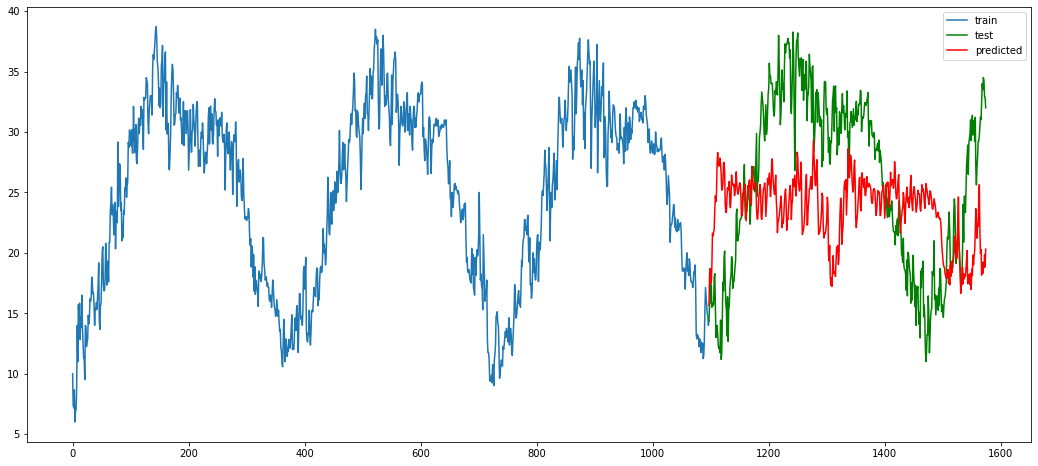

In [229]:
fig, ax = plt.subplots()
plt.plot(np.append(train, test.values[0]))
plt.plot(test, color='green')
plt.plot(predictions, color="red")
ax.legend(['train', 'test', 'predicted'])
plt.show()

In [230]:
mse = mean_squared_error(test, predictions_lstm)
print(f'MSE = {round(mse,3)}')

MSE = 61.412


In [231]:
rmse = np.sqrt(mse)
print(f'RMSE = {round(rmse,3)}')

RMSE = 7.837
